In [1]:
import os
import requests
import json, re, time
from urllib.parse import urljoin
from pathlib import Path


BASE = os.getenv("OPENWEBUI_BASE", "https://ai.create.kcl.ac.uk")  # no trailing slash
TOKEN = os.getenv("OPENWEBUI_TOKEN", "sk-67123084b3384c1a8f70461dd9c60c5b")                 # don't hardcode in code
TIMEOUT = 120
TRANSCRIPT_PATH = f"psychs_transcripts"

In [2]:
_session = requests.Session()

def _headers():
    return {
        "Authorization": f"Bearer {TOKEN}",
        "Content-Type": "application/json",
        "Accept": "application/json",   
    }

def _url(path: str) -> str:
    # ensure exactly one slash between base and path
    return urljoin(BASE.rstrip("/") + "/", path.lstrip("/"))

def collect_ids(obj):
    found = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k == "id":
                found.append(v)
            found.extend(collect_ids(v))
    elif isinstance(obj, list):
        for item in obj:
            found.extend(collect_ids(item))
    return found

def list_models():
    """
    Returns the raw JSON from /api/models.
    Most Open WebUI builds return {"data": [ ...models... ]}.
    """
    r = _session.get(_url("/api/models"), headers=_headers(), timeout=TIMEOUT)
    r.raise_for_status()
    return r.json()


def _post_json(path: str, payload: dict):
    # IMPORTANT: use a longer read timeout to avoid partial responses
    r = _session.post(
        _url(path),
        headers=_headers(),
        json=payload,
        timeout=(10, 300),
    )

    def _parse_response_text(txt: str, ctype: str):
        if not txt or not txt.strip():
            raise RuntimeError("Empty response body (server returned no JSON).")

        s = txt.lstrip()
        # JSON-as-text with wrong content-type
        if s.startswith("{") or s.startswith("["):
            return json.loads(s)

        # SSE or noisy logs
        if "text/event-stream" in ctype or "data:" in txt:
            chunks = []
            for line in txt.splitlines():
                line = line.strip()
                if not line.startswith("data:"):
                    continue
                if line == "data: [DONE]":
                    break
                try:
                    obj = json.loads(line[5:].strip())
                except Exception:
                    continue
                ch = (obj.get("choices") or [{}])[0]
                delta = ch.get("delta") or {}
                piece = delta.get("content")
                if piece is None:
                    msg = ch.get("message") or {}
                    piece = msg.get("content")
                if piece:
                    chunks.append(piece)
            if chunks:
                return {"choices": [{"message": {"content": "".join(chunks)}}]}

        # HTML error page or mixed logs: try to pull first JSON object
        m = re.search(r"\{.*\}", txt, flags=re.S)
        if m:
            try:
                return json.loads(m.group(0))
            except Exception:
                pass

        # Give a helpful error
        snippet = txt[:500].replace("\n", "\\n")
        raise RuntimeError(
            f"Unexpected non-JSON response (content-type={ctype}). "
            f"First 500 chars: {snippet}"
        )

    if r.status_code >= 400:
        # return server body snippet to help debug
        raise RuntimeError(f"{r.status_code} {_url(path)}\nResponse: {r.text[:500]}")

    ctype = (r.headers.get("content-type") or "").lower()

    # Try normal JSON first
    try:
        if "application/json" in ctype:
            return r.json()
        return _parse_response_text(r.text, ctype)
    except Exception as e:
        # One quick retry (server sometimes flushes late / returns partial)
        time.sleep(0.5)
        r2 = _session.post(
            _url(path),
            headers=_headers(),
            json=payload,
            timeout=(10, 300),
        )
        if r2.status_code >= 400:
            raise RuntimeError(f"{r2.status_code} {_url(path)}\nResponse: {r2.text[:500]}")
        ctype2 = (r2.headers.get("content-type") or "").lower()
        if "application/json" in ctype2:
            return r2.json()
        return _parse_response_text(r2.text, ctype2)
    
def _pick_model(explicit: str | None = None) -> str:
    if explicit:
        return explicit
    raw = list_models()
    models = raw.get("data") if isinstance(raw, dict) else raw
    if not models:
        raise RuntimeError("No models available on this Open WebUI server.")
    first = models[0]
    # handle either dict or plain string
    if isinstance(first, dict):
        return first.get("id") or first.get("name") or next(iter(first.values()))
    return str(first)

def _extract_assistant_text(data: dict) -> str:
    """
    Works with OpenAI-compatible responses.
    """
    # Typical: {"choices":[{"message":{"role":"assistant","content":"..."}}]}
    try:
        return data["choices"][0]["message"]["content"]
    except (KeyError, IndexError, TypeError):
        # Some servers use "content" directly on the choice
        try:
            return data["choices"][0]["content"]
        except Exception:
            raise RuntimeError(f"Unexpected response schema:\n{data}")

def chat(msg: str, model: str | None = None) -> str:
    model = _pick_model(model)
    payload = {"model": model, "messages": [{"role": "user", "content": msg}],"stream": False}

    # Try documented path first, then OpenAI-compatible fallback
    errors = []
    for path in ("/api/chat/completions", "/v1/chat/completions"):
        try:
            data = _post_json(path, payload)
            return _extract_assistant_text(data)
        except RuntimeError as e:
            errors.append(f"{path} -> {e}")

    raise RuntimeError("Both endpoints failed:\n\n" + "\n\n".join(errors))


# if __name__ == "__main__":
#     print(chat("Say hi in one sentence."))


In [4]:

transcript_files = [f for f in Path(TRANSCRIPT_PATH).glob("*.txt") 
                   if "prompt" not in f.name and "assessment" not in f.name]
target_ids = {"BM97794", "ME39294", "NC30190"}

matches = [f for f in transcript_files if any(tid in f.name for tid in target_ids)]
matches = transcript_files
outputs_dir = Path("outputs_score")
outputs_dir.mkdir(parents=True, exist_ok=True)
models_all = ['gemma3n:latest','gpt-oss:20b','qwen3']

In [6]:

# All at once
prompt_name = 'Dom_v2'
with open(f'prompt_{prompt_name}.txt', 'r') as f:
    prompt_template = f.read()

for model in models_all[1:]:

    for transcript_file in matches:
        with open(transcript_file, "r", encoding="utf-8") as f:
            transcript = f.read()

        prompt = prompt_template.format(transcript=transcript)

        print(f"\nProcessing: {transcript_file.name}")
        assessment = chat(prompt,model)  # or generate_assessment(prompt, model="qwen3")

        output_file = str(transcript_file).replace(".txt", f"_assessment_{prompt_name}_{model}.txt")
        out_path = outputs_dir / output_file
        out_path.parent.mkdir(parents=True, exist_ok=True)

        with open(out_path, "w", encoding="utf-8") as f:
            f.write(f"File: {transcript_file.name}\n")
            f.write("=" * 50 + "\n")
            f.write(assessment)

        print(f"Saved: {out_path}")
        break




Processing: PronetBI_BI19401_interviewAudioTranscript_psychs_day0013_session001_REDACTED.txt
Saved: outputs_score/psychs_transcripts/PronetBI_BI19401_interviewAudioTranscript_psychs_day0013_session001_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt

Processing: PronetBI_BI19401_interviewAudioTranscript_psychs_day0013_session001_REDACTED.txt
Saved: outputs_score/psychs_transcripts/PronetBI_BI19401_interviewAudioTranscript_psychs_day0013_session001_REDACTED_assessment_Dom_v2_qwen3.txt


In [ ]:
from typing import Optional, List

_num = r'[-+]?(?:\d+(?:\.\d+)?|\.\d+)(?:[eE][-+]?\d+)?'  # int, float, .float, sci

def _to_float(s: str) -> float:
    s = s.replace(",", "")  # allow "1,234.5"
    # s matches _num by construction, so float() is safe without try/except
    return float(s)

# use int?
def extract_number(text: str) -> Optional[float]:
    """
    Returns the first 'meaningful' number it finds:
      1) percentage like '87%'  -> 87.0
      2) fraction  like '4/6'   -> 4.0  (numerator)
      3) plain number           -> value
    If none found, returns None.
    """
    # 1) percentage
    m = re.search(rf'(?<!\d)({_num})\s*%', text)
    if m:
        return _to_float(m.group(1))

    # 2) fraction (return the numerator as the number)
    m = re.search(rf'({_num})\s*/\s*({_num})', text)
    if m:
        return _to_float(m.group(1))

    # 3) plain number
    m = re.search(rf'({_num})', text)
    return _to_float(m.group(1)) if m else None

In [17]:
# Step by step

# Severity
#  
model ='gemma3n:latest'
prompt_name = 'Alejo'
with open(f'prompt_{prompt_name}_sev.txt', 'r') as f:
    prompt_template = f.read()

sev_scores = []
for transcript_file in matches:
    with open(transcript_file, "r", encoding="utf-8") as f:
        transcript = f.read()

    prompt = prompt_template.format(transcript=transcript)

    print(f"\nProcessing: {transcript_file.name}")
    assessment = chat(prompt,model)  # or generate_assessment(prompt, model="qwen3")
    sev_score = extract_number(assessment)
    sev_scores.append(sev_score)
    print(f'Estimated severity score: {sev_score}')

    output_file = str(transcript_file).replace(".txt", f"_assessment_{prompt_name}_sev_{model}.txt")
    out_path = outputs_dir / output_file
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with open(out_path, "w", encoding="utf-8") as f:
        f.write(f"File: {transcript_file.name}\n")
        f.write("=" * 50 + "\n")
        f.write(assessment)

    print(f"Saved: {out_path}")


Processing: PrescientBM_BM97794_interviewAudioTranscript_psychs_day0001_session001_REDACTED.txt
Estimated severity score: 3.0
Saved: outputs_score/psychs_transcripts/PrescientBM_BM97794_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Alejo_sev_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0094_session004_REDACTED.txt
Estimated severity score: 2.0
Saved: outputs_score/psychs_transcripts/PrescientME_ME39294_interviewAudioTranscript_psychs_day0094_session004_REDACTED_assessment_Alejo_sev_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0043_session002_REDACTED.txt
Estimated severity score: 3.0
Saved: outputs_score/psychs_transcripts/PrescientME_ME39294_interviewAudioTranscript_psychs_day0043_session002_REDACTED_assessment_Alejo_sev_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0038_session001_REDACTED.txt
Estimated severity score: 2.0
Saved: outpu

In [22]:
# Step by step

# Frequency

with open(f'prompt_{prompt_name}_freq.txt', 'r') as f:
    prompt_template = f.read()

freq_scores = []
for transcript_file,sev_score in zip(matches,sev_scores):
    with open(transcript_file, "r", encoding="utf-8") as f:
        transcript = f.read()

    prompt = prompt_template.format(transcript=transcript,sev_score=sev_score)

    print(f"\nProcessing: {transcript_file.name}")
    assessment = chat(prompt,model)  # or generate_assessment(prompt, model="qwen3")

    output_file = str(transcript_file).replace(".txt", f"_assessment_{prompt_name}_freq_{model}.txt")
    out_path = outputs_dir / output_file
    out_path.parent.mkdir(parents=True, exist_ok=True)
    freq_score = extract_number(assessment)
    freq_scores.append(freq_score)
    print(f'Estimated frequency score: {freq_score}')

    with open(out_path, "w", encoding="utf-8") as f:
        f.write(f"File: {transcript_file.name}\n")
        f.write("=" * 50 + "\n")
        f.write(assessment)

    print(f"Saved: {out_path}")


Processing: PrescientBM_BM97794_interviewAudioTranscript_psychs_day0001_session001_REDACTED.txt
Estimated frequency score: 2.0
Saved: outputs_score/psychs_transcripts/PrescientBM_BM97794_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Alejo_freq_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0094_session004_REDACTED.txt
Estimated frequency score: 1.0
Saved: outputs_score/psychs_transcripts/PrescientME_ME39294_interviewAudioTranscript_psychs_day0094_session004_REDACTED_assessment_Alejo_freq_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0043_session002_REDACTED.txt
Estimated frequency score: 3.0
Saved: outputs_score/psychs_transcripts/PrescientME_ME39294_interviewAudioTranscript_psychs_day0043_session002_REDACTED_assessment_Alejo_freq_gemma3n:latest.txt

Processing: PrescientME_ME39294_interviewAudioTranscript_psychs_day0038_session001_REDACTED.txt
Estimated frequency score: 40.0
Save

In [ ]:
# Step by step

# Summary

with open(f'prompt_{prompt_name}_sum.txt', 'r') as f:
    prompt_template = f.read()


for transcript_file,sev_score,freq_score in zip(matches,sev_scores,freq_scores):
    with open(transcript_file, "r", encoding="utf-8") as f:
        transcript = f.read()

    prompt = prompt_template.format(transcript=transcript,sev_score=sev_score,freq_score=freq_score)

    print(f"\nProcessing: {transcript_file.name}")
    assessment = chat(prompt,model)  # or generate_assessment(prompt, model="qwen3")

    output_file = str(transcript_file).replace(".txt", f"_assessment_{prompt_name}_sum_{model}.txt")
    out_path = outputs_dir / output_file
    out_path.parent.mkdir(parents=True, exist_ok=True)


    with open(out_path, "w", encoding="utf-8") as f:
        f.write(f"File: {transcript_file.name}\n")
        f.write("=" * 50 + "\n")
        f.write(assessment)

    print(f"Saved: {out_path}")


Processing: PronetNC_NC30190_interviewAudioTranscript_psychs_day0001_session001_REDACTED.txt
Saved: outputs_score/psychs_transcripts/PronetNC_NC30190_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Alejo_sum_gemma3n:latest.txt


In [31]:
# BM97794 (Severity = 3; Frequency = 3)
# ME39294 day 38 (Severity = 4; Frequency = 6)
# NC30190 (Severity = 6; Frequency = 5)
collect_ids(list_models())

['qwen3',
 'qwen3',
 'qwen3',
 'gpt-oss:20b',
 'gpt-oss:20b',
 'gpt-oss:20b',
 'gemma3n:latest',
 'gemma3n:latest',
 'gemma3n:latest',
 'gemma3:1b',
 'gemma3:1b',
 'gemma3:1b']

{'data': [{'id': 'qwen3',
   'object': 'model',
   'created': 1677610602,
   'owned_by': 'openai',
   'connection_type': 'external',
   'name': 'Qwen 3',
   'openai': {'id': 'qwen3',
    'object': 'model',
    'created': 1677610602,
    'owned_by': 'openai',
    'connection_type': 'external'},
   'urlIdx': 1,
   'info': {'id': 'qwen3',
    'user_id': 'd911f021-a51e-4148-9351-c5638f7adaf9',
    'base_model_id': None,
    'name': 'Qwen 3',
    'params': {'temperature': 0.6,
     'top_p': 0.95,
     'top_k': 20,
     'min_p': 0,
     'presence_penalty': 0,
     'max_tokens': 32768},
    'meta': {'profile_image_url': '',
     'description': 'Qwen3-30B-A3B-Thinking-2507',
     'capabilities': {'vision': False,
      'file_upload': True,
      'web_search': True,
      'image_generation': False,
      'code_interpreter': True,
      'citations': True,
      'usage': True},
     'suggestion_prompts': None,
     'tags': []},
    'access_control': None,
    'is_active': True,
    'updated_at': 
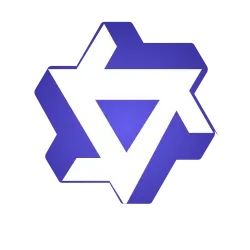
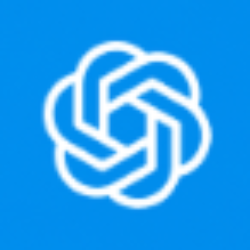
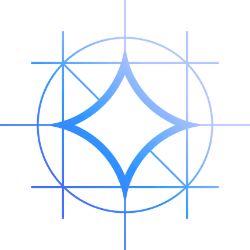
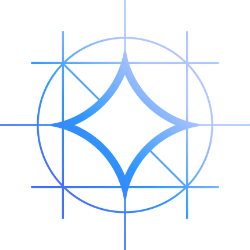

In [7]:
list_models()